2024-06-07 06:01:36.104724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 06:01:36.246918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-07 06:01:36.246942: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-07 06:01:36.278387: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 06:01:37.039588: W tensorflow/stream_executor/pla

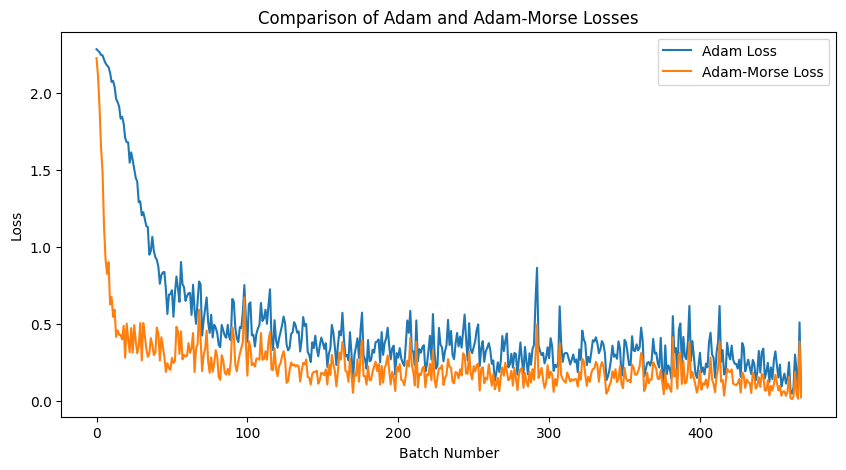

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# Load MNIST dataset
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28)).astype('float32') / 255
train_labels = to_categorical(train_labels)

# Define a simple neural network
def initialize_params(input_dim, hidden_dim, output_dim):
    np.random.seed(42)
    W1 = np.random.randn(input_dim, hidden_dim) * 0.01
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) * 0.01
    b2 = np.zeros((1, output_dim))
    return W1, b1, W2, b2

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def compute_loss(Y, Y_hat):
    m = Y.shape[0]
    return -np.sum(Y * np.log(Y_hat + 1e-8)) / m

def forward_prop(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(X, Y, Z1, A1, Z2, A2, W1, W2):
    m = X.shape[0]
    dZ2 = A2 - Y
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    return dW1, db1, dW2, db2

def update_params_with_adam(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate, t, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2, beta1, beta2, epsilon):
    mW1 = beta1 * mW1 + (1 - beta1) * dW1
    mb1 = beta1 * mb1 + (1 - beta1) * db1
    mW2 = beta1 * mW2 + (1 - beta1) * dW2
    mb2 = beta1 * mb2 + (1 - beta1) * db2
    vW1 = beta2 * vW1 + (1 - beta2) * (dW1 ** 2)
    vb1 = beta2 * vb1 + (1 - beta2) * (db1 ** 2)
    vW2 = beta2 * vW2 + (1 - beta2) * (dW2 ** 2)
    vb2 = beta2 * vb2 + (1 - beta2) * (db2 ** 2)
    mW1_corr = mW1 / (1 - beta1 ** t)
    mb1_corr = mb1 / (1 - beta1 ** t)
    mW2_corr = mW2 / (1 - beta1 ** t)
    mb2_corr = mb2 / (1 - beta1 ** t)
    vW1_corr = vW1 / (1 - beta2 ** t)
    vb1_corr = vb1 / (1 - beta2 ** t)
    vW2_corr = vW2 / (1 - beta2 ** t)
    vb2_corr = vb2 / (1 - beta2 ** t)
    W1 -= learning_rate * mW1_corr / (np.sqrt(vW1_corr) + epsilon)
    b1 -= learning_rate * mb1_corr / (np.sqrt(vb1_corr) + epsilon)
    W2 -= learning_rate * mW2_corr / (np.sqrt(vW2_corr) + epsilon)
    b2 -= learning_rate * mb2_corr / (np.sqrt(vb2_corr) + epsilon)
    return W1, b1, W2, b2, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2

def classify_critical_point(gradient):
    norm_gradient = np.linalg.norm(gradient)
    return 'min' if norm_gradient < 1e-5 else 'saddle'

def floer_homotopy_perturbation(params, iteration):
    perturbation_strength = 0.1 / (1 + iteration * 1e-4)
    perturbation = np.sin(params * 10) * perturbation_strength
    return perturbation

def J(u, gradient, iteration):
    critical_point_type = classify_critical_point(gradient)
    if critical_point_type == 'saddle':
        alpha = 1.5
        modified_gradient = gradient * alpha
        return modified_gradient
    elif critical_point_type == 'min':
        beta = 0.1
        floer_perturbation = floer_homotopy_perturbation(u, iteration)
        return gradient + beta * gradient + floer_perturbation
    else:
        return gradient

def update_params_with_adam_morse(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate, t, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2, beta1, beta2, epsilon, iteration):
    mW1 = beta1 * mW1 + (1 - beta1) * dW1
    mb1 = beta1 * mb1 + (1 - beta1) * db1
    mW2 = beta1 * mW2 + (1 - beta1) * dW2
    mb2 = beta1 * mb2 + (1 - beta1) * db2
    vW1 = beta2 * vW1 + (1 - beta2) * (dW1 ** 2)
    vb1 = beta2 * vb1 + (1 - beta2) * (db1 ** 2)
    vW2 = beta2 * vW2 + (1 - beta2) * (dW2 ** 2)
    vb2 = beta2 * vb2 + (1 - beta2) * (db2 ** 2)
    mW1_corr = mW1 / (1 - beta1 ** t)
    mb1_corr = mb1 / (1 - beta1 ** t)
    mW2_corr = mW2 / (1 - beta1 ** t)
    mb2_corr = mb2 / (1 - beta1 ** t)
    vW1_corr = vW1 / (1 - beta2 ** t)
    vb1_corr = vb1 / (1 - beta2 ** t)
    vW2_corr = vW2 / (1 - beta2 ** t)
    vb2_corr = vb2 / (1 - beta2 ** t)
    dW1 = J(W1, mW1, iteration)
    db1 = J(b1, mb1, iteration)
    dW2 = J(W2, mW2, iteration)
    db2 = J(b2, mb2, iteration)
    W1 -= learning_rate * dW1 / (np.sqrt(vW1) + epsilon)
    b1 -= learning_rate * db1 / (np.sqrt(vb1) + epsilon)
    W2 -= learning_rate * dW2 / (np.sqrt(vW2) + epsilon)
    b2 -= learning_rate * db2 / (np.sqrt(vb2) + epsilon)
    return W1, b1, W2, b2, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2


# Initialize parameters for both Adam and Adam-Morse
W1, b1, W2, b2 = initialize_params(784, 128, 10)
mW1, mb1, mW2, mb2 = np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2)
vW1, vb1, vW2, vb2 = np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2)

# Copy parameters for Adam-Morse
W1_morse, b1_morse, W2_morse, b2_morse = np.copy(W1), np.copy(b1), np.copy(W2), np.copy(b2)
mW1_morse, mb1_morse, mW2_morse, mb2_morse = np.copy(mW1), np.copy(mb1), np.copy(mW2), np.copy(mb2)
vW1_morse, vb1_morse, vW2_morse, vb2_morse = np.copy(vW1), np.copy(vb1), np.copy(vW2), np.copy(vb2)

# Training loop for Adam and Adam-Morse
adam_losses = []
adam_morse_losses = []
batch_size = 128
num_batches = train_images.shape[0] // batch_size

for i in range(num_batches):
    X_batch = train_images[i * batch_size:(i + 1) * batch_size]
    Y_batch = train_labels[i * batch_size:(i + 1) * batch_size]
    
    # Forward propagation for both optimizers
    Z1, A1, Z2, A2 = forward_prop(X_batch, W1, b1, W2, b2)
    Z1_morse, A1_morse, Z2_morse, A2_morse = forward_prop(X_batch, W1_morse, b1_morse, W2_morse, b2_morse)
    
    # Compute gradients
    dW1, db1, dW2, db2 = backward_prop(X_batch, Y_batch, Z1, A1, Z2, A2, W1, W2)
    dW1_morse, db1_morse, dW2_morse, db2_morse = backward_prop(X_batch, Y_batch, Z1_morse, A1_morse, Z2_morse, A2_morse, W1_morse, W2_morse)
    
    # Update parameters using Adam
    W1, b1, W2, b2, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2 = update_params_with_adam(
        W1, b1, W2, b2, dW1, db1, dW2, db2, 0.001, i+1, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2, 0.9, 0.999, 1e-8)
    
    # Update parameters using Adam-Morse
    W1_morse, b1_morse, W2_morse, b2_morse, mW1_morse, mb1_morse, mW2_morse, mb2_morse, vW1_morse, vb1_morse, vW2_morse, vb2_morse = update_params_with_adam_morse(
        W1_morse, b1_morse, W2_morse, b2_morse, dW1_morse, db1_morse, dW2_morse, db2_morse, 0.001, i+1, mW1_morse, mb1_morse, mW2_morse, mb2_morse, vW1_morse, vb1_morse, vW2_morse, vb2_morse, 0.9, 0.999, 1e-8, i+1)

    # Calculate loss for Adam and Adam-Morse
    loss_adam = compute_loss(Y_batch, softmax(np.dot(relu(np.dot(X_batch, W1) + b1), W2) + b2))
    loss_adam_morse = compute_loss(Y_batch, softmax(np.dot(relu(np.dot(X_batch, W1_morse) + b1_morse), W2_morse) + b2_morse))

    adam_losses.append(loss_adam)
    adam_morse_losses.append(loss_adam_morse)

# Plotting the losses for comparison
plt.figure(figsize=(10, 5))
plt.plot(adam_losses, label='Adam Loss')
plt.plot(adam_morse_losses, label='Adam-Morse Loss')
plt.title('Comparison of Adam and Adam-Morse Losses')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=756a2cf6-30bf-4d75-a01b-fc300f6f9700' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>